In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
%matplotlib inline

# I. Load the data, clean it and extract usefull information

In [2]:
nodes = pd.read_csv("./NTDS_Data/census_and_vote_data.csv" )
migflow2015_county_nodeid_dist = pd.read_csv("./NTDS_Data/migflow2015_county_nodeid_dist.csv")

In [3]:
# drop useless columns : ori_county and des_county use FSPE code as indexes, we are using a inhouse indexing
mig_flow = migflow2015_county_nodeid_dist.drop(columns=["ori_county", "des_county", "dist_km"])

In [4]:
num_nodes = nodes.values.shape[0]
num_flows = mig_flow.shape[0]
print(num_nodes)


1838


# II. Create the Adjency matrix

In [5]:
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
for i in range (0, num_flows) : 
    total = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_total[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_returns[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i]/total
    A_exemptions[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["exemptions"][i]/total

In [6]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

2.05213148790842


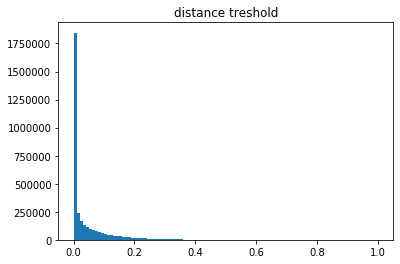

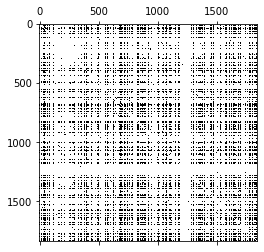

(1838, 1838)


In [7]:
adjacency = epsilon_similarity_graph(A_returns, sigma=2.05*0.25, epsilon=0.1)
plt.spy(adjacency)
plt.show()
print(adjacency.shape)

In [45]:
graph = nx.from_numpy_array(adjacency)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(graph, node_props[key], key)



/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


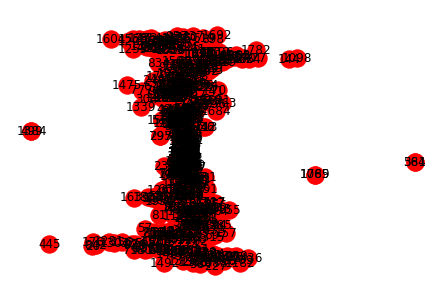

In [9]:
nx.draw_spectral(graph, with_labels=True)
#nx.write_gexf(graph, 'result.gexf')

In [46]:
list0 = node[node["result"]==0]
list1 = node[node["result"]==1]

In [47]:
list0

,id,result
2,3.0,0.0
3,4.0,0.0
6,7.0,0.0
11,12.0,0.0
12,13.0,0.0
13,14.0,0.0
15,16.0,0.0
17,18.0,0.0
29,30.0,0.0
33,34.0,0.0


In [38]:
node_props["id"][0]

1.0

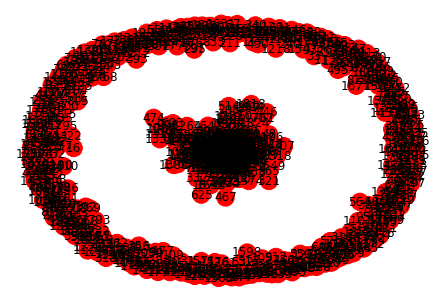

In [48]:
color_map = []
for node in graph:
    if node in list0:
        #print(node)
        color_map.append('blue') # <0.5
    else: 
        print("red :",node)
        color_map.append('red')  # >=0.5    
nx.draw(graph,node_color = color_map,with_labels = True)
plt.show()

/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/xzou/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


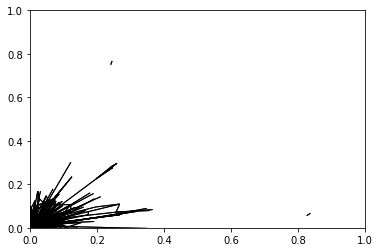

In [29]:
pos=nx.spring_layout(graph)
nx.draw_networkx_edges(graph,pos,with_labels=True,
                       nodelist=list0,
                       node_color='r')
nx.draw_networkx_edges(graph,pos,with_labels=True,
                       nodelist=list1,
                       node_color='b')

In [ ]:
#draw_networkx_edges